# Описание проекта
---
Компания ***«Чётенькое такси»*** собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.  
Значение метрики RMSE на тестовой выборке должно быть не больше 48.  

Столбец **`num_orders`** - количество заказов

# Выполнение проекта
---

### Содержание:  
<font size=4><ol>
<li>Получение и первичный анализ данных</li>
<li>Подготовка признаков</li>
<li>Обучение моделей</li>
<li>Тестирование лучшей модели</li>
<li>Выводы</li>
</ol></font>

---

### 1. Получение и первичный анализ данных  

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

Получим данные для анализа

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])

In [3]:
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [5]:
df.duplicated().sum()

0

Интервал задан в 10 минут. Пропусков и дубликатов нет. Установим столбец в датой и временем в качестве индекса таблицы, и проверим их отсортированность.

In [6]:
df = df.set_index('datetime')
df.index.is_monotonic_increasing

True

Проведем ресэмплирование данных до 1 часа, в соответствии с заданием.

In [7]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Для лучшей визуализации создадим скользящее среднее и стандартное отклонение за 1 день (24 часа). Чтобы само значение num_orders не влияло на значение скользящих значение, установим параметр `closed='left'`, который не включает нижнюю границу.

In [8]:
df['rolling_mean_day'] = df['num_orders'].rolling(24, closed='left').mean()
df['rolling_std_day'] = df['num_orders'].rolling(24, closed='left').std()

Построим визуализацию временного ряда, в том числе скользящего среднего и стандартного отклонения.

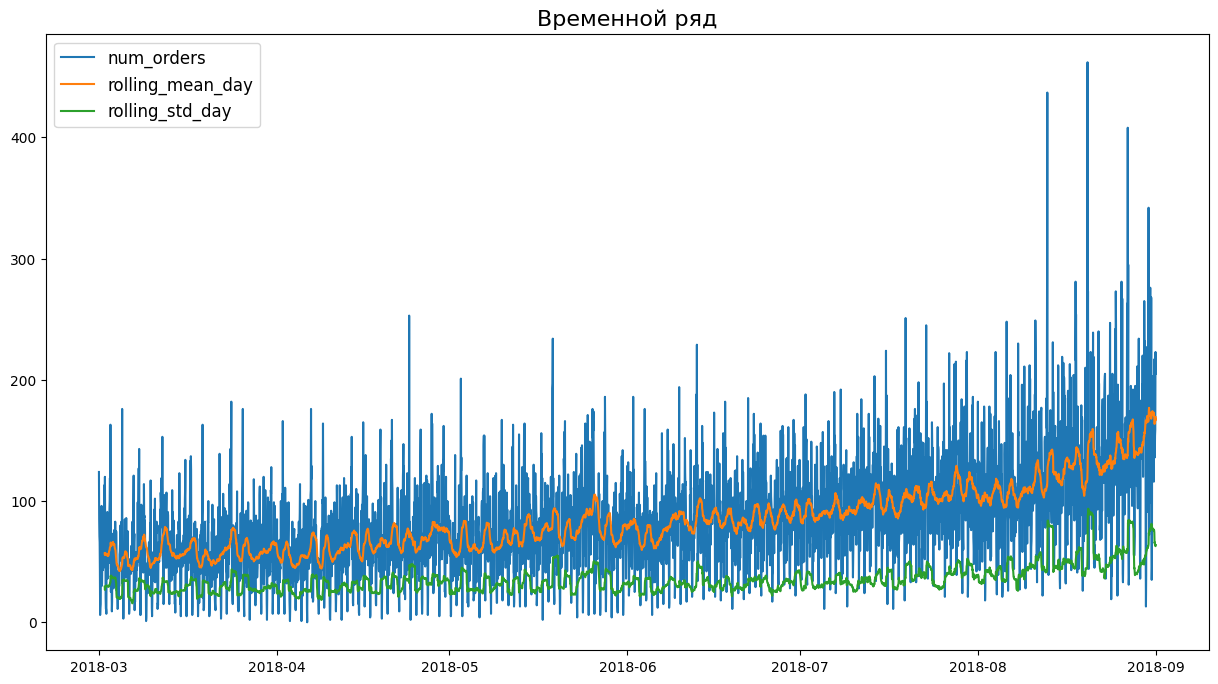

In [9]:
plt.figure(figsize=(15, 8)) 
plt.plot(df)
plt.legend(loc='upper left', labels=['num_orders', 'rolling_mean_day', 'rolling_std_day'], fontsize=12)
plt.title('Временной ряд', fontsize=16)
plt.show()

Среднее растёт. Посмотрим в другом разрезе - оценим тренд и сезонность.

In [10]:
decomposed = seasonal_decompose(df[['num_orders']])

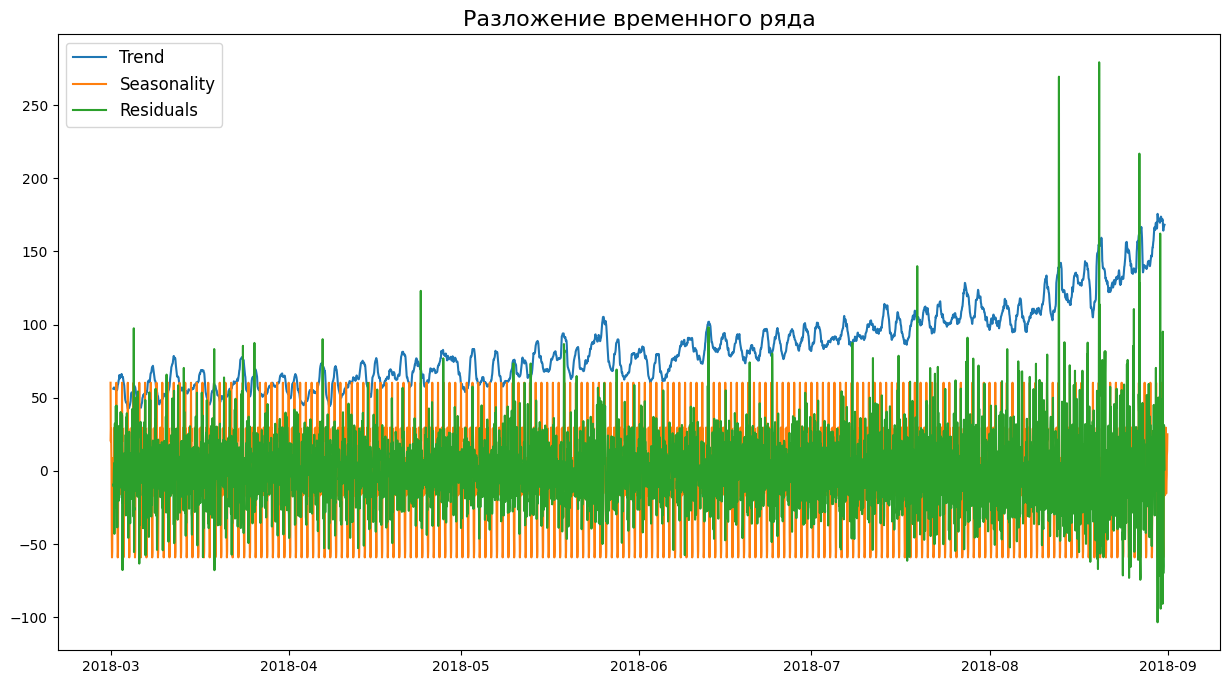

In [11]:
plt.figure(figsize=(15, 8)) 
plt.plot(decomposed.trend)
plt.plot(decomposed.seasonal)
plt.plot(decomposed.resid)
plt.legend(loc='upper left', labels=['Trend', 'Seasonality', 'Residuals'], fontsize=12)
plt.title('Разложение временного ряда', fontsize=16)
plt.show()

Да, есть тренд на увеличение, однако оно кажется не слишком сильным чтобы вызвать сложности прогнозирования.

Рассмотрим сезонность подробнее.

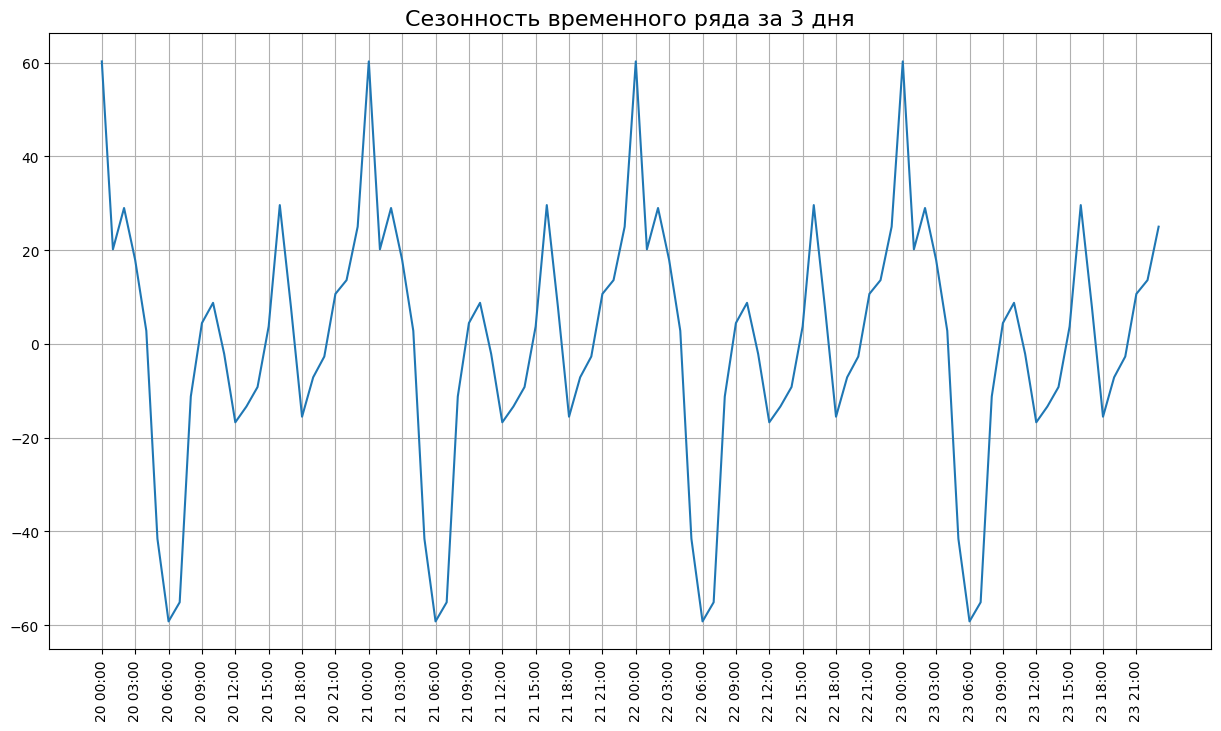

In [12]:
plt.figure(figsize=(15, 8)) 
plt.plot(decomposed.seasonal['2018-08-20':'2018-08-23']) 
plt.xticks(ticks=pd.date_range(start='2018-08-20 0:00:00', 
                               end='2018-08-23 23:00:00', 
                               freq='3H'), 
           labels=['{:%d %H:%M}'.format(i) for i in pd.date_range(start='2018-08-20 0:00:00', 
                                                                  end='2018-08-23 23:00:00', 
                                                                  freq='3H')], 
           rotation=90)
plt.grid(True)
plt.title('Сезонность временного ряда за 3 дня', fontsize=16)
plt.show()

Видно, что наибольшая активность (количество заказов) приходится на 12 часов ночи, а минимальная на 6 утра. Поскольку речь идёт о заказах такси в аэропорт, можно предположить, что это связано с тем, что людям удобнее всего закончить дела в течение дня, полететь вечером куда им надо и лечь спать по приезду в место назначения, чем терять на дорогу ночь и "сбивать" свой режим. Возможно так же сказывается то, что перестаёт ходить общественный транспорт.

Так же рассмотрим сезонность в течение недели.

In [13]:
days_decompose = seasonal_decompose(df[['num_orders']].resample('1D').sum()).seasonal

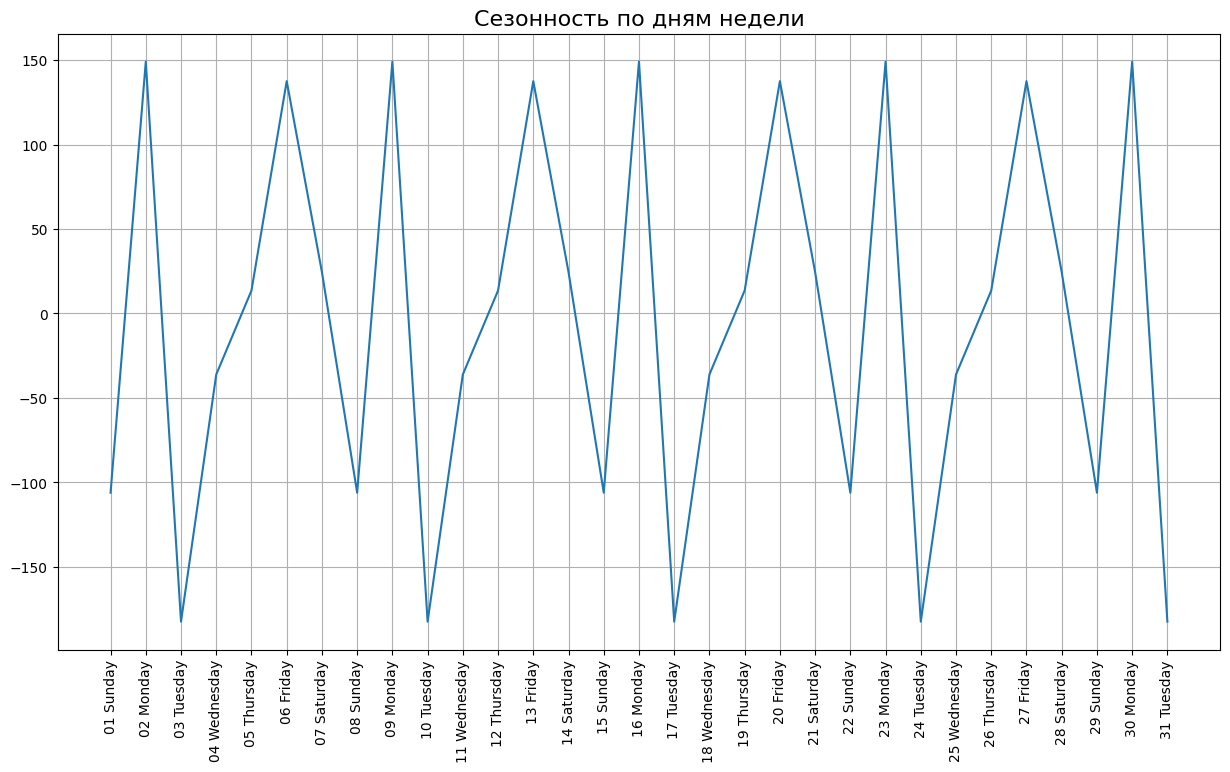

In [14]:
plt.figure(figsize=(15, 8))
plt.plot(days_decompose['2018-07'])
plt.title('Сезонность по дням недели', fontsize=16)
plt.xticks(ticks=pd.date_range('2018-07-01', '2018-07-31'), rotation=90, 
           labels=['{:%d %A}'.format(i) for i in pd.date_range('2018-07-01', '2018-07-31')])
plt.grid(True)
plt.show()

Наибольшее число заказов имеем по понедельникам и пятницам, что логично. Например слетать куда-то на выходных - в пятницу прилетел туда, в понедельник прилетел обратно в трудовые будни.

### 2. Подготовка признаков

Добавим новые признаки - извлечем из даты день и день недели.

In [15]:
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

Так же добавим столбцы со смещением, и отдельно найдем разность вчерашних и текущих значений.

In [16]:
df['lag_1'] = df['num_orders'].shift(1)
df['lag_2'] = df['num_orders'].shift(2)
df['lag_3'] = df['num_orders'].shift(3)
df['lag_4'] = df['num_orders'].shift(4)

df['num_orders_diff'] = df['num_orders'] - df['lag_1']

Посмотрим на корреляцию получившихся признаков, возможно что-то придётся убрать.

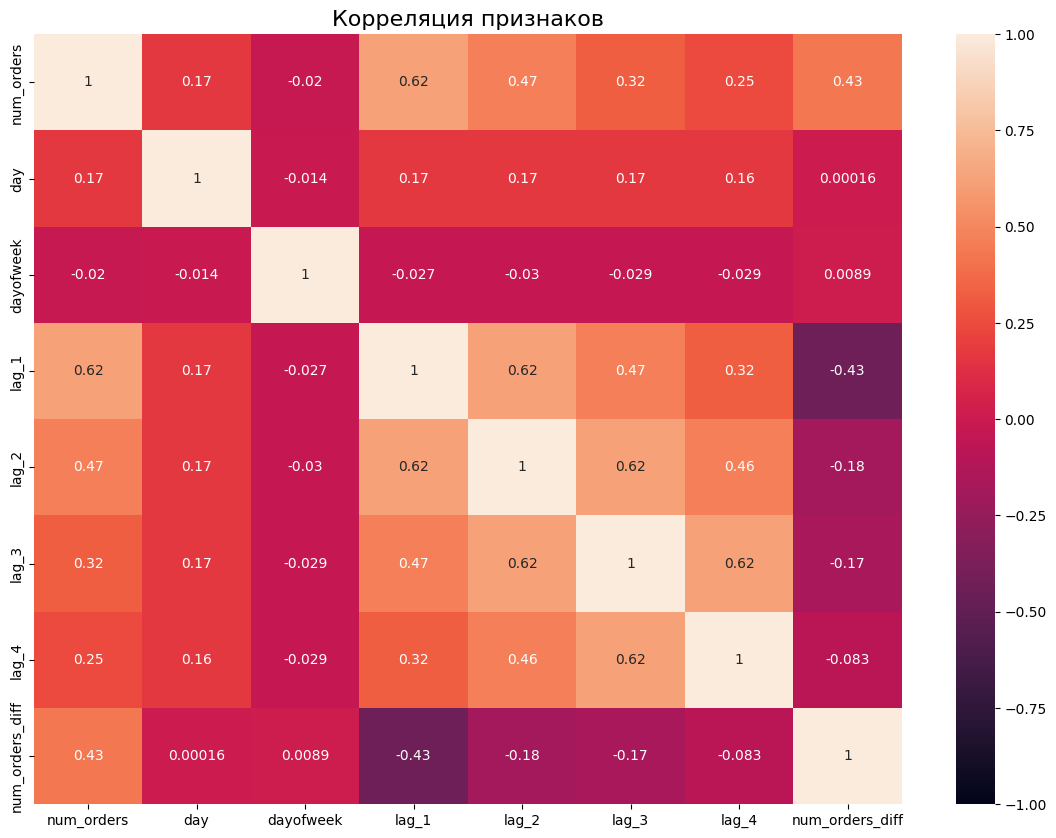

In [17]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.drop(columns=['rolling_std_day', 'rolling_mean_day']).dropna().corr(), 
            vmax=1, vmin=-1, annot=True)
plt.title('Корреляция признаков', fontsize=16)
plt.show()

Уберем скользящее среднее и стандартное отклонение.  

Разделим данные на обучающую и тестовую выборки, создадим таблицу признаков и целевого значения - обучающую и тестовую.

In [18]:
train, test = train_test_split(df.drop(columns=['rolling_std_day', 'rolling_mean_day']), 
                               test_size=0.1, shuffle=False)

print(train.shape, test.shape)

train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

(3974, 8) (442, 8)


Так же зафиксируем алгоритм сплитования. Пусть количество подвыборок будет таким, чтобы размер валидационной выборки соответствовал размеру тестовой выборки. Поскольку ***1/10*** часть первоначального датасета "ушла" на тестовую выборку, у нас осталось ***9/10***, и чтобы прогнать их через кросс-валидацию понадобится 8 сплитов. т.е. в первой итерации будут использоваться ***2/10*** (***1/10*** - тренировочная, ***1/10*** валидационная), в каждой последующей размер тренировочной выборки будет увеличиваться на ***1/10*** и к 8 разу достигнет всего объёма данных.

In [19]:
tscv = TimeSeriesSplit(n_splits=8)

### 3. Обучение моделей

Попробуем применить несколько моделей линейной регрессии, обучить их и оценить точность прогноза с помощью кросс-валидации.

In [20]:
%%time
model_lr = LinearRegression()
cv_result = cross_val_score(estimator=model_lr, X=features_train, y=target_train, 
                            scoring='neg_root_mean_squared_error', cv=tscv)

print('Результаты модели линейной регрессии RMSE = {:.3f}'.format(cv_result.mean()))
print()

Результаты модели линейной регрессии RMSE = -0.000

CPU times: user 21.3 ms, sys: 3.55 ms, total: 24.9 ms
Wall time: 21.1 ms


И сразу ноль. Это даже пугает. Время на обучение бодро стремится к нулю.

Для следующих моделей нужно подобрать оптимальные параметры, сделаем это через GridSearch, но для удобства напишеми функцию.

In [21]:
def model_result(grid_model, features, target):
    grid_model.fit(features, target)
    print('Лучший результат RMSE решающего дерева = {:.2f}'.format(grid_model.best_score_)) 
    print('Время обучения модели = {:.5f} сек.'.format(grid_model.cv_results_['mean_fit_time'].mean()))
    print('Лучшие параметры модели =', grid_model.best_params_)

In [22]:
model_dt = DecisionTreeRegressor(random_state=123)
grid_dt = GridSearchCV(estimator=model_dt, n_jobs=-1, cv=tscv, 
                       param_grid={'max_depth': [i for i in range(2, 12)]}, 
                       scoring='neg_root_mean_squared_error')

model_result(grid_dt, features_train, target_train)

Лучший результат RMSE решающего дерева = -8.62
Время обучения модели = 0.00562 сек.
Лучшие параметры модели = {'max_depth': 11}


Уже не ноль, но ошибка не большая. В пределах обозначенного диапазона. Оптимальная глубина дерева - 10, время обучения так же ничтожно мало.  
Градиентный бустинг, должен показать лучшие результаты.

In [23]:
model_xgb = XGBRegressor(learning_rate=0.1, n_jobs=-1)
grid_xgb = GridSearchCV(estimator=model_xgb, n_jobs=-1, cv=tscv, 
                        param_grid={'max_depth': [i for i in range(2, 12)], 
                                    'n_estimators': [i for i in range(10, 101, 10)]}, 
                        scoring='neg_root_mean_squared_error')

model_result(grid_xgb, features_train, target_train)

Лучший результат RMSE решающего дерева = -5.15
Время обучения модели = 0.10356 сек.
Лучшие параметры модели = {'max_depth': 3, 'n_estimators': 100}


Так и оказалось. Ошибка небольшая, но с нулем не сравнить.  
На всякий случай проверим что говорит константная модель в таком случае.

In [24]:
model_dummy = DummyRegressor(strategy='mean')
model_dummy.fit(features_train, target_train)
print('RMSE DummyRegressor = {:.0f}'.format(
      mean_squared_error(y_pred=model_dummy.predict(features_test), 
                          y_true=target_test, squared=False)))

RMSE DummyRegressor = 85


Константа сильно отстает. Побеждает **`LinearRegression()`**.

### 4. Тестирование лучшей модели

На основе полученных выше данных, для обучения и применения на тестовой выборке будем использовать модель линейной регрессии **`LinearRegression()`**. В ней нулевая ошибка и почти не затрачивается время.

In [25]:
model = LinearRegression()
model.fit(features_train, target_train)
predict = model.predict(features_test)
print('RMSE линейной регрессии на тестовых данных = {:.3f}'.format(
    mean_squared_error(y_true=target_test, y_pred=predict, squared=False)))

RMSE линейной регрессии на тестовых данных = 0.000


Как и было обещано.  

Сравним полученные прогнозные значения с реальными на графике.

In [26]:
result_df = target_test.reset_index()
result_df['predict'] = predict
result_df = result_df.set_index('datetime')
result_df

,num_orders,predict
datetime,,
2018-08-13 14:00:00,102,102.0
2018-08-13 15:00:00,175,175.0
2018-08-13 16:00:00,144,144.0
2018-08-13 17:00:00,152,152.0
2018-08-13 18:00:00,104,104.0
...,...,...
2018-08-31 19:00:00,136,136.0
2018-08-31 20:00:00,154,154.0
2018-08-31 21:00:00,159,159.0


Возьмём интервал в 4 дня.

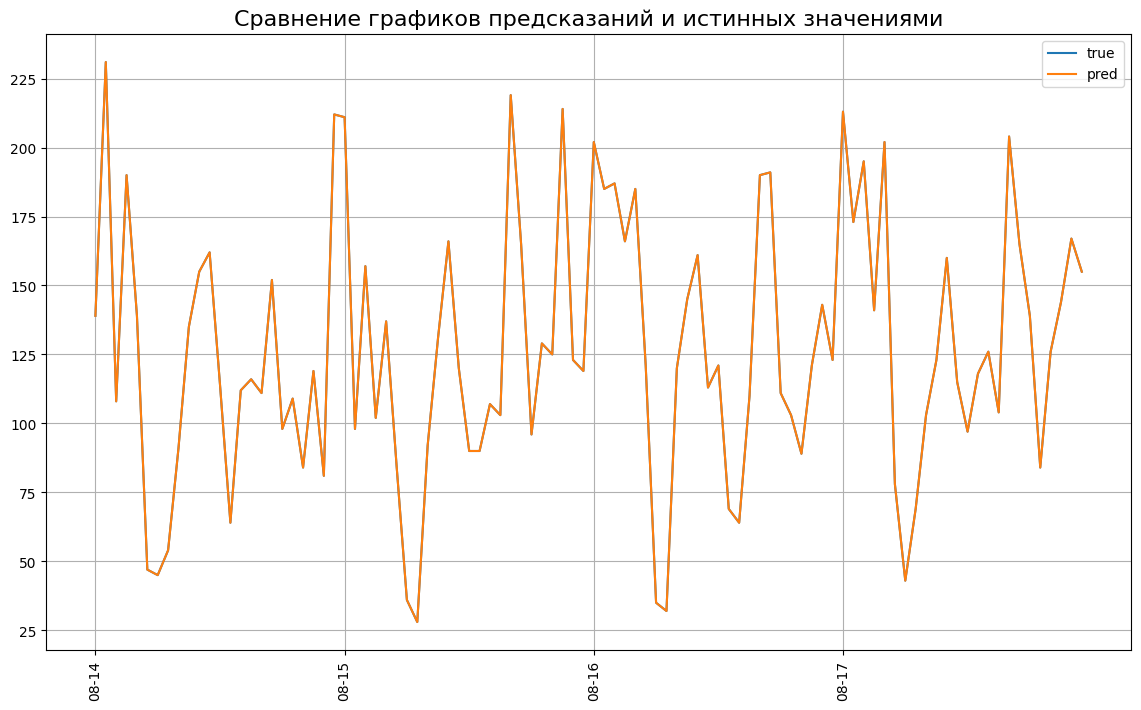

In [34]:
plt.figure(figsize=(14, 8))
plt.plot(result_df['2018-08-14':'2018-08-17']['num_orders'])
plt.plot(result_df['2018-08-14':'2018-08-17']['predict'])
plt.xticks(ticks=pd.date_range('2018-08-14', '2018-08-17'), rotation=90, 
           labels=['{:%m-%d}'.format(i) for i in pd.date_range('2018-08-14', '2018-08-17')])
plt.title('Сравнение графиков предсказаний и истинных значениями', fontsize=16)
plt.legend(loc='upper right', labels=['true', 'pred'])
plt.grid(True)
plt.show()

Судя по всему графики полностью совпадают.

In [35]:
result_df['predict'] = result_df['predict'].round().astype('int64')
result_df['diff'] = result_df['num_orders'] - result_df['predict']
result_df['diff'].unique()

array([0])

Да, значения полностью повторяются.

### 5. Выводы

- Временной ряд имеет тренд на изменение (не стохастический), но поддаётся прогнозированию.
- Есть тренд на рост значений, в то же время становится больше "шума".
- Применные модели машинного обучения справились с прогнозом значений, в пределах заданных в условии задачи значений.
- Лучший результат показала модель **`LinearRegression()`**, метрика RMSE = 0.
- Наибольшее значение метрики ошибки у решающего дерева **`DecisionTreeRegressor`** = -8.6.
- Константная модель показала ошибку = 85.